# ML on ESDC using TensorFlow 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook showcases how to implement Machine Learning on the Earth System Data Cube using TensorFlow for multidimensional data containing gaps. In the following example those values are replaced with the sample mean in order to enable the application of Machine Learning.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

**This notebook runs needs a python conda environment with tensorflow installed, please checkout the documentation for help on [changing the environment](https://deepesdl.readthedocs.io/en/v2022.12.1/guide/jupyterlab/). You can follow the experiment run via the bundled Tensorboard UI.**

### Import necessary libraries

In [1]:
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger().setLevel(logging.ERROR)

import datetime
import numpy as np
import xarray as xr
import dask.array as da
import tensorflow as tf
from global_land_mask import globe
from tensorflow.keras import layers as L
from xcube.core.store import new_data_store

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset    = data_store.open_data("esdc-8d-0.083deg-184x270x270-2.1.1.zarr")
ds         = dataset[["land_surface_temperature", "air_temperature_2m"]]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Train/Test Split assignment
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [3]:
from ml4xcube.splits import assign_rand_split, assign_block_split

# random sampling
#xds = assign_rand_split(
#    ds    = xdsm,
#    split = 0.8
#)

# block sampling
xds = assign_block_split(
    ds         = ds,
    block_size = [("time", 10), ("lat", 100), ("lon", 100)],
    split      = 0.8
)
xds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Train-/ and Test Set Creation and Preprocessing

Initialize XrDataset to analyze 10x10 data samples considering spatial relations. A sample is dropped if it containes entirely missing values for at least one ESDC variable (`drop_nan = 'if_all_nan'`). The gaps within the data are replaced utilizing the sample mean (`fill_method = 'sample_mean'`).

In [4]:
from ml4xcube.datasets.xr_dataset import XrDataset

sampler = XrDataset(
    ds            = xds, 
    chunk_indices = [841], 
    sample_size   = [("time", 1), ("lat", 10), ("lon", 10)],
    to_pred       = "land_surface_temperature",
    drop_nan      = 'if_all_nan',
    fill_method   = 'sample_mean'
)

train_data, test_data = sampler.get_datasets()
X_train, y_train      = train_data 
X_test, y_test        = test_data

X_train.shape, y_train.shape, X_test.shape, y_test.shape

set train and test data


((72422, 1, 10, 10),
 (72422, 1, 10, 10),
 (17899, 1, 10, 10),
 (17899, 1, 10, 10))

Flatten all samples

In [5]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((72422, 100), (72422, 100), (17899, 100), (17899, 100))

#### Prepare Datasets before Training

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128)

### Define model and optimizer

In [7]:
# Create model
inputs      = L.Input(name="air_temperature_2m", shape=(100,))
output      = L.Dense(100, activation="linear", name="land_surface_temperature")(inputs)
model       = tf.keras.models.Model(inputs=inputs, outputs=output)
model.compile(optimizer="adam", loss="mse")

model.summary()

model.optimizer.learning_rate.assign(0.001)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ air_temperature_2m (InputLayer) │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ land_surface_temperature        │ (None, 100)            │        10,100 │
│ (Dense)                         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,100 (39.45 KB)

 Trainable params: 10,100 (39.45 KB)

 Non-trainable params: 0 (0.00 B)

### Enable logging for Tensorboard

In [8]:
log_dir = os.environ.get('TENSORBOARD_LOGDIR', 'logs') + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

### Train model

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 1.7856 - val_loss: 2.1707
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4101 - val_loss: 1.0886
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7097 - val_loss: 0.8957
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0407 - val_loss: 0.8262
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7472 - val_loss: 0.7413
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2076 - val_loss: 0.6856
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1464 - val_loss: 0.4398
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6192 - val_loss: 0.3308
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5916 - val_loss: 0.3392
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4661 - val_loss: 0.3709
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3097 - val_loss: 0.3274
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3982 - val_loss: 0.6252
Epoch 13/2

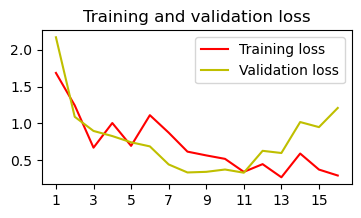

In [9]:
from ml4xcube.training.tensorflow import Trainer

trainer = Trainer(
    model            = model,
    train_data       = train_ds,
    test_data        = test_ds,
    early_stopping   = True,
    patience         = 5,
    model_path       = "./best_model.keras",
    tf_log_dir       = log_dir,
    epochs           = 20,
    create_loss_plot = True
)

model = trainer.train()